In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 32 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PhoGra',qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr) #,reformat=False
code.global_options()

# BSE analysis for bulk MoS$_2$

We compute the absorption spectrum of the monolayer MoS$_2$ within the BSE framework.

We make usage of the convergence analysis and of the ndb databases created in the GW runlevel

First we build and init the run directories and perform link off the ndb database computed
in the GW analysis

In [4]:
kpoints = ['12x12x2','18x18x3']

for k in kpoints:
    source_dir = 'BULK-DFT_analysis/kpoints_%s-nbnds_200.save'%k
    run_dir = 'BULK-BSE_analysis/kpoints_%s-nbnds_200'%k
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

SAVE folder BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-BSE_analysis/kpoints_12x12x2-nbnds_200. No operations performed.
SAVE folder BULK-DFT_analysis/kpoints_18x18x3-nbnds_200.save/SAVE already present. No operations performed.
Create folder path BULK-BSE_analysis/kpoints_18x18x3-nbnds_200
Create a symlink of BULK-DFT_analysis/kpoints_18x18x3-nbnds_200.save/SAVE in BULK-BSE_analysis/kpoints_18x18x3-nbnds_200
Build the r_setup in the run_dir path BULK-BSE_analysis/kpoints_18x18x3-nbnds_200


We create a link of the folders with the ndb database created in the _GW_analysis_ in the _BSE_analysis_ folder

In [5]:
def find_ndbs(path):
    ndbs =  []
    files = os.listdir(path)
    for f in files:
        if 'ndb_' in f : ndbs.append(os.path.abspath(os.path.join(path,f)))
    return ndbs

def make_link(ndbs,dest):
    abs_dest = os.path.abspath(dest)
    for ndb in ndbs:
        ndb_name = ndb.split('/')[-1]
        target = os.path.join(abs_dest,ndb_name)
        if not os.path.isdir(target):
            print(ndb,target)
            os.symlink(ndb,target,target_is_directory=True)

In [6]:
for k in kpoints:
    ndbs = find_ndbs('BULK-GW_analysis/kpoints_%s-nbnds_200/'%k)
    print(ndbs)
    make_link(ndbs,'BULK-BSE_analysis/kpoints_%s-nbnds_200/'%k)

['/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW_analysis/kpoints_12x12x2-nbnds_200/ndb_em1d-ngsblkxp_2.0-bndsrnxp_200', '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW_analysis/kpoints_12x12x2-nbnds_200/ndb_dipoles-nbnds_200', '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW_analysis/kpoints_12x12x2-nbnds_200/ndb_em1d-ngsblkxp_4.0-bndsrnxp_200', '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW_analysis/kpoints_12x12x2-nbnds_200/ndb_em1d-ngsblkxp_6.0-bndsrnxp_200', '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW_analysis/kpoints_12x12x2-nbnds_200/ndb_em1d-ngsblkxp_8.0-bndsrnxp_200', '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW_analysis/kpoints_12x12x2-nbnds_200/ndb_em1d-ngsblkxp_10.0-bndsrnxp_200']
['/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW_analysis/kpoints_18x18x3-nbnds_200/ndb_dipoles-nbnds_200', '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-GW

## BSE convergence analysis for the low energy excitations

We test the optimal BSE parameters by constructing the absorption spectrum in the low
energy range.

The analysis is performed on-top of the DFT computations using a scissor to reproduce the 
experimental gap

In [7]:
dft_gap = 1.81 # eV at the K point
gw_gap = 2.36 # eV computed for the 12x12x2 with 8 Ha of cutoff in the em1
scissor = gw_gap-dft_gap # eV
print('scissor',scissor)
kpoints = ['12x12x2','18x18x3']

scissor 0.5499999999999998


We test the convergence of the spectrum w.r.t to various parameters in the BSE calculation

We perform this analysis in the 12x12x2 grid

In [53]:
k = kpoints[0]
run_dir = 'BULK-BSE_analysis/kpoints_%s-nbnds_200/'%k


BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 20. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [[51,54],[49,54],[49,56],[49,58],[47,58]]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
for bsebands in BSEBands:
    inp.set_array_variables(BSEBands=bsebands)
    idd = 'bse-bsengblk_%s-bsebands_%s-%s'%(BSENGBlk,bsebands[0],bsebands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,',ndb_em1d-ngsblkxp_8.0-bndsrnxp_200','ndb_dipoles-bnds_200'])

Initialize a Dataset with 2 parallel tasks


In [54]:
#study.runs[1]

In [55]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
Skip the run of bse-bsengblk_3.0-bsebands_51-54Skip the run of
 bse-bsengblk_3.0-bsebands_49-54
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of bse-bsengblk_3.0-bsebands_49-56
Skip the run of bse-bsengblk_3.0-bsebands_49-58
Task [2, 3] ended 
 
Run the task [4] 
Skip the run of bse-bsengblk_3.0-bsebands_47-58
Task [4] ended 
 


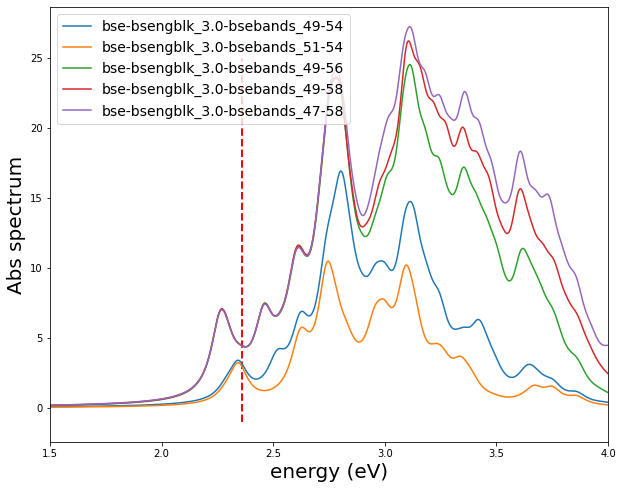

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    data = r.data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label=study.ids[ind]) 
ax.vlines(gw_gap,-1,25,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that including the bands from 49 to 56 is sufficient for the convergence of the lowest part of the spectrum.

Next we test the BSENGBlk parameter

In [57]:
k = kpoints[0]
run_dir = 'BULK-BSE_analysis/kpoints_%s-nbnds_200/'%k


BSENGBlk = [3.0,4.0] # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 20. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [49,56]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
inp.set_array_variables(BSEBands=BSEBands)
for bsengblk in BSENGBlk:
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=bsengblk,FFTGvecs=FFTGvecs)
    idd = 'bse-bsengblk_%s-bsebands_%s-%s'%(bsengblk,BSEBands[0],BSEBands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,',ndb_em1d-ngsblkxp_8.0-bndsrnxp_200','ndb_dipoles-bnds_200'])

Initialize a Dataset with 1 parallel tasks


In [51]:
#study.runs[1]

In [58]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
Skip the run of bse-bsengblk_3.0-bsebands_49-56
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo -F bse-bsengblk_4.0-bsebands_49-56.in -J "bse-bsengblk_4.0-bsebands_49-56,,ndb_em1d-ngsblkxp_8.0-bndsrnxp_200,ndb_dipoles-bnds_200" -C bse-bsengblk_4.0-bsebands_49-56
slurm submit:  cd BULK-BSE_analysis/kpoints_12x12x2-nbnds_200/ ; sbatch job_bse-bsengblk_4.0-bsebands_49-56.sh
computation bse-bsengblk_4.0-bsebands_49-56 is running...
computation bse-bsengblk_4.0-bsebands_49-56 ended
Run performed in 01m-42s
Task [1] ended 
 


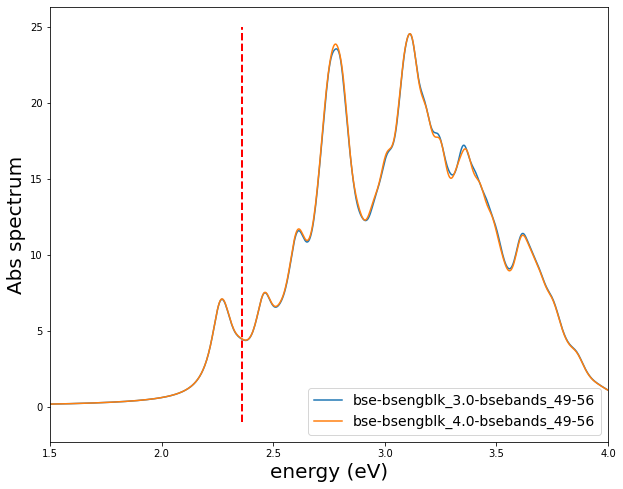

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    data = r.data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label=study.ids[ind]) 
ax.vlines(gw_gap,-1,25,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that BSENGBlk = 3.0 Ha is sufficient for the convergence.

Next we test the convergence w.r.t to $k$-points samplings

In [8]:
BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 20. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [49,56]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'BULK-BSE_analysis/kpoints_%s-nbnds_200/'%k
    inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step)
    inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
    inp.set_array_variables(BSEBands=BSEBands)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    idd = 'bse-bsengblk_%s-bsebands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,',ndb_em1d-ngsblkxp_8.0-bndsrnxp_200','ndb_dipoles-bnds_200'])

Initialize a Dataset with 1 parallel tasks


In [10]:
study.runs[1]

{'label': 'Dataset',
 'run_dir': 'BULK-BSE_analysis/kpoints_18x18x3-nbnds_200/',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -o b -k sex -y h',
  'folder': 'BULK-BSE_analysis/kpoints_18x18x3-nbnds_200/',
  'filename': 'yambo.in',
  'arguments': ['bse', 'optics', 'bss', 'photolum'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'BSENGexx': [20.0, 'Ha'],
   'BSENGBlk': [3.0, 'Ha'],
   'BEnSteps': [1000, ''],
   'BSHayTrs': [-0.02, ''],
   'BSKmod': 'SEX',
   'BSEmod': 'resonant',
   'BSSmod': 'h',
   'BSEprop': 'abs',
   'BSEdips': 'none',
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[49, 56], ''],
   'BEnRange': [[0, 4], 'eV'],
   'BDmRange': [[0.05, 0.05], 'eV'],
   'BLongDir': [[1.0, 0.0, 0.0], ''],
   'KfnQP_E': [[0.5499999999999998, 1.0, 1.0], ''],
   'BS_CPU': '32.1.1',
   'BS_ROLEs': 'k.eh.t',
   'FFTGvecs': [30.0, 'Ha']}},
 'jobname': ['bse-bsengblk_3.0-bsebands_49-56-kpoints_18x18x3',
  ',ndb_em1

In [11]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F bse-bsengblk_3.0-bsebands_49-56-kpoints_12x12x2.in -J "bse-bsengblk_3.0-bsebands_49-56-kpoints_12x12x2,,ndb_em1d-ngsblkxp_8.0-bndsrnxp_200,ndb_dipoles-bnds_200" -C bse-bsengblk_3.0-bsebands_49-56-kpoints_12x12x2
slurm submit:  cd BULK-BSE_analysis/kpoints_12x12x2-nbnds_200/ ; sbatch job_bse-bsengblk_3.0-bsebands_49-56-kpoints_12x12x2.sh
computation bse-bsengblk_3.0-bsebands_49-56-kpoints_12x12x2 is running...
computation bse-bsengblk_3.0-bsebands_49-56-kpoints_12x12x2 ended
Run performed in 01m-12s
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo -F bse-bsengblk_3.0-bsebands_49-56-kpoints_18x18x3.in -J "bse-bsengblk_3.0-bsebands_49-56-kpoints_18x18x3,,ndb_em1d-ngsblkxp_8.0-bndsrnxp_200,ndb_dipoles-bnds_200" -C bse-bsengblk_3.0-bsebands_49-56-kpoints_18x18x3
slurm submit:  cd BULK-BSE_analysis/kpoints_18x18x3-nbnds_200/ ; sbatch job_bse-bsengblk_3

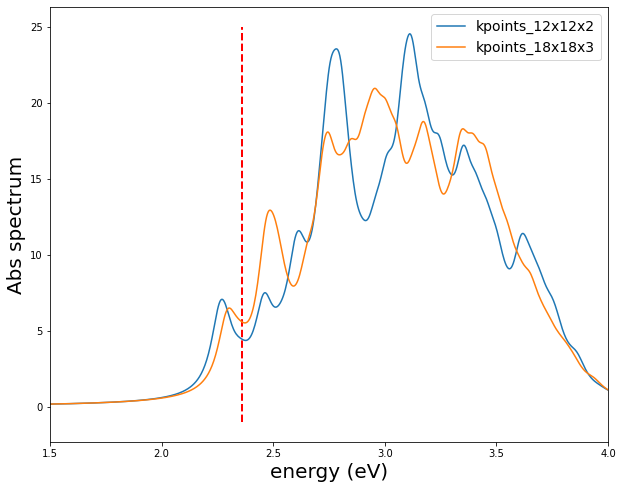

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='kpoints_%s'%k) 
ax.vlines(gw_gap,-1,25,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
#ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that the results are qualitatively similar, but the 18x18x3 one better reprdouce
the feature of the spectrum reported in the literature.

## BSE analysis of the XUV spectrum

We compute the absorption spectrum due to the semicore electrons at the BSE level.

In this analysis we restric the transition from the bands xxx to xxx that should correspond
to the 6 4p states of the Mo atom (with the j=1/2 and j=3/2 states splitted by the SOC) to
the conduction bands 27 and 28.

In [4]:
dft_gap = 1.81 # eV at the K point
gw_gap = 2.36 # eV computed for the 12x12x2 with 8 Ha of cutoff in the em1
scissor = gw_gap-dft_gap # eV
print('scissor',scissor)
kpoints = ['12x12x2','18x18x3']

scissor 0.5499999999999998


In [20]:
k = kpoints[0]
run_dir = 'BULK-BSE_analysis/kpoints_%s-nbnds_200/'%k

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 20. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]

BSEBands = [5,58]
BSEHoleBands =  [5,16] #[5,12]
BSEElecBands = [[53,58]] #[[53,54],[53,56],[53,58]] 

energy_range = [0,50] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
for elecbands in BSEElecBands:
    inp.set_array_variables(BSEBands=BSEBands,BSEHoleBands=BSEHoleBands,BSEElecBands=elecbands)
    idd = 'bse-xuv-holebands_%s-%s-elecbands_%s-%s'%(BSEHoleBands[0],
                    BSEHoleBands[1],elecbands[0],elecbands[1])    
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,',ndb_em1d-ngsblkxp_8.0-bndsrnxp_200','ndb_dipoles-bnds_200'])

Initialize a Dataset with 2 parallel tasks


In [21]:
#study.runs[1]

In [22]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F bse-xuv-holebands_5-16-elecbands_53-58.in -J "bse-xuv-holebands_5-16-elecbands_53-58,,ndb_em1d-ngsblkxp_8.0-bndsrnxp_200,ndb_dipoles-bnds_200" -C bse-xuv-holebands_5-16-elecbands_53-58
slurm submit:  cd BULK-BSE_analysis/kpoints_12x12x2-nbnds_200/ ; sbatch job_bse-xuv-holebands_5-16-elecbands_53-58.sh
computation bse-xuv-holebands_5-16-elecbands_53-58 is running...
computation bse-xuv-holebands_5-16-elecbands_53-58 ended
Run performed in 12m-22s
Task [0] ended 
 


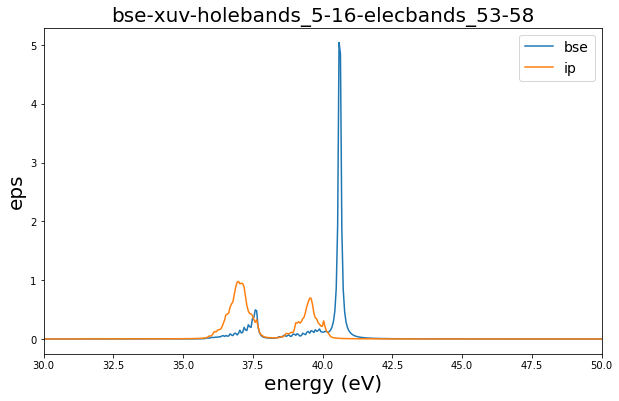

In [23]:
for ind,r in results.items():
    fig, ax = plt.subplots(figsize=(10, 6))
    eps = r.data['eps_q1_haydock_bse']
    energy = eps['energy']
    eps_im = eps['eps_imag']
    eps_o_im = eps['eps_o_imag']
    ax.plot(energy,eps_im,label='bse')
    ax.plot(energy,eps_o_im,label='ip')
    ax.set_title(study.ids[ind],size=20)
    ax.set_ylabel('eps',size=20)
    ax.set_xlabel('energy (eV)',size=20)
    ax.set_xlim(30,50)
    ax.legend(fontsize=14)
    plt.show()

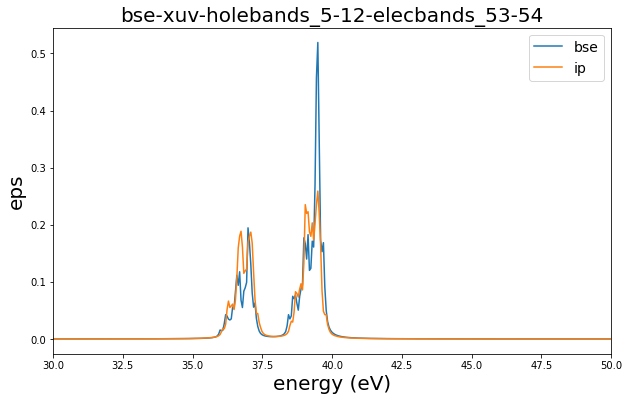

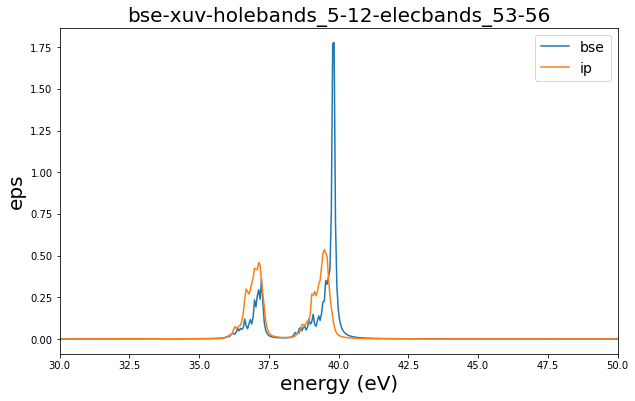

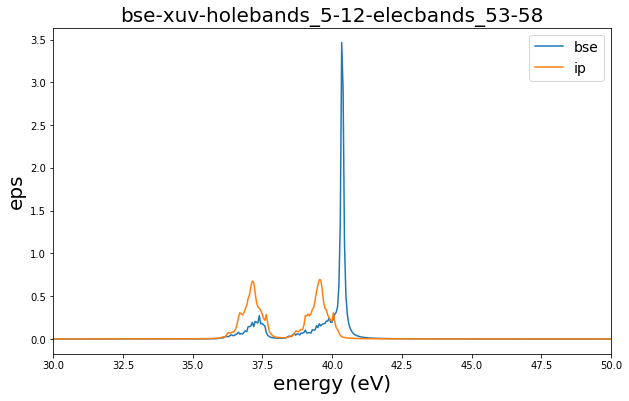

In [19]:
for ind,r in results.items():
    fig, ax = plt.subplots(figsize=(10, 6))
    eps = r.data['eps_q1_haydock_bse']
    energy = eps['energy']
    eps_im = eps['eps_imag']
    eps_o_im = eps['eps_o_imag']
    ax.plot(energy,eps_im,label='bse')
    ax.plot(energy,eps_o_im,label='ip')
    ax.set_title(study.ids[ind],size=20)
    ax.set_ylabel('eps',size=20)
    ax.set_xlabel('energy (eV)',size=20)
    ax.set_xlim(30,50)
    ax.legend(fontsize=14)
    plt.show()